In [3]:
import substation_analysis_functions
from substation_analysis_functions import *
from imp import reload
reload(substation_analysis_functions)
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


In [104]:
df = pd.read_csv('../consumer_data_counts_by_substation.csv')
#df.set_index('substation', inplace = True)
df

,substation,Commercial,Features,Land,Military,Mixed,Parent Shell,Residential,Unclassified
0,76 Church Road,0.050847,0.005650,0.005650,0.000000,0.011299,0.045198,0.870056,0.011299
1,87 Howard Street,0.072994,0.002100,0.038767,0.000000,0.001249,0.051708,0.833182,0.000000
2,Ambrosden Park Rise,0.067114,0.003132,0.114094,0.001342,0.000000,0.049217,0.765101,0.000000
3,Barry Avenue,0.050450,0.001058,0.039513,0.000176,0.000000,0.040395,0.868407,0.000000
4,Bridge View Watlington Road,0.083072,0.000470,0.043574,0.000000,0.000157,0.055486,0.817241,0.000000
...,...,...,...,...,...,...,...,...,...
97,the perch binsey,0.048708,0.004428,0.080074,0.000000,0.000738,0.059041,0.806642,0.000369
98,units 13/14 Oxford science pk,0.136957,0.000000,0.015217,0.000000,0.006522,0.073913,0.767391,0.000000
99,venables close,0.049278,0.002266,0.040782,0.000000,0.001416,0.054092,0.852167,0.000000
100,windmill st deddington,0.139878,0.003182,0.035528,0.000000,0.000142,0.045645,0.775625,0.000000


### Clustering on land use type

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_46429/757491681.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clusters.groupby('Cluster').mean().plot(kind='bar', figsize=(8, 4), title = 'Cluster means', colormap = 'viridis')


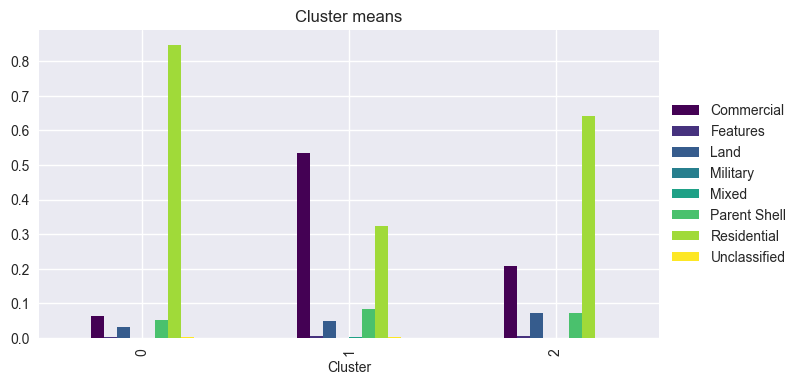

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_46429/757491681.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clusters.loc[c].groupby('Cluster').mean().plot(kind='bar', figsize=(8, 4), title = 'Datapoints closest to cluster centers', colormap = 'viridis')


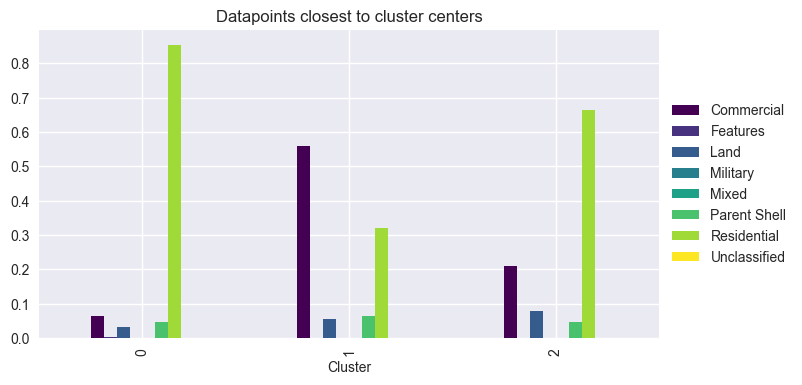

In [111]:
def k_means_clustering(df, k):
    # Select columns 2 through 8 as the feature set
    X = df.iloc[:, 1:9].values
    # Initialize the KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    # Fit the KMeans model to the feature set
    kmeans.fit(X)
    
    # Add the predicted cluster labels to the DataFrame
    df['Cluster'] = kmeans.labels_
    
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    closest
    
    # Return the DataFrame with the predicted cluster labels and center indices
    return df,closest

df_clusters, center_idx = k_means_clustering(df, 3)

# Plot the cluster means and plot the data points closest to the cluster centers
df_clusters.groupby('Cluster').mean().plot(kind='bar', figsize=(8, 4), title = 'Cluster means', colormap = 'viridis')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
df_clusters.loc[c].groupby('Cluster').mean().plot(kind='bar', figsize=(8, 4), title = 'Datapoints closest to cluster centers', colormap = 'viridis')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


### Now look at the active power profiles in each cluster to see if clustering by consumer type leads to distinct active power clusters

In [91]:
# Using k = 3
df_clusters, center_idx = k_means_clustering(df, 3)
# Lets look at the active power profiles for each cluster
# Load in active power data and clean it...
folder_path = "../Substation Busbar Data/"
dataframes = substation_analysis_functions.read_substation_data(folder_path)
dataframes = substation_analysis_functions.handle_missing_vals(dataframes, threshold = 0.5)
for substation, df in dataframes.items():
    dataframes[substation] = substation_analysis_functions.detect_bad_power_vals(df,active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100)   
    

### Plot the active power profiles for each cluster
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
for substation in df_clusters.iloc[center_idx]['substation']:
    #plt.plot(dataframes[substation].index, dataframes[substation]['Active Power [kW]'])
 
    
    plt.style.use('seaborn')
    # Plot all active power profiles
    dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
    ax1.plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').median(), label=substation)
    ax1.set_title(f'Active Power Load Profiles')
    ax1.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Representative Substations')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('kW')
   # ax1.set_ylim(0, 750)

    # Plot all reactive power profiles
    dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
    ax2.plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').median(), label=substation)
    ax2.set_title(f'Reactive Power Load Profiles')
    ax2.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Representative Substations')
    ax2.set_xlabel('Hour of the Day')
    ax2.set_ylabel('kVAr')
   # ax2.set_ylim(-50,110)

Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000